# 1. Import Dependencies and Data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds # Bringing Tensorflow datasets for fashion mnist
from matplotlib import pyplot as plt
import numpy as np # For data Transformation.

# 2. Build Data and Viz Data

In [2]:
# loading 'fashion mnist' data-set from Tensorflow(loading only training-data)
ds = tfds.load('fashion_mnist', split='train')

In [3]:
itr = ds.as_numpy_iterator()

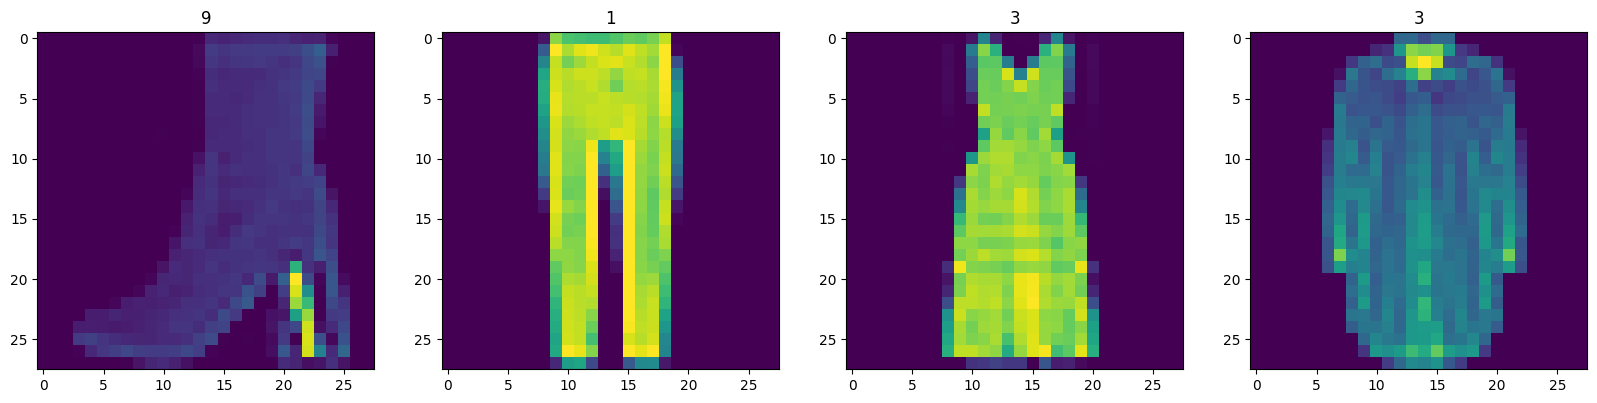

In [19]:
# Viz Training Data-set(loading from Tensorflow)
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for indx in range(4):
    sample = itr.next()
    ax[indx].imshow(np.squeeze(sample['image'])) # np.squeeze() - Removes dimentions of size 1(simplifies data shape and makes simpler to work with) eg: (28, 28, 1) ---> (28, 28)
    ax[indx].title.set_text(sample['label'])

In [20]:
# Scale data(between 0 to 1), and returns Image only(because we don't need lables)
def normalize(sample):
    img = sample['image'] # Extract Image only.
    return img / 255 

In [21]:
# Data Pre-Processing
# Normalize-data
ds = ds.map(normalize) # map() is used to apply a function to each element in a dataset
# Chache dataset(for fast access to data-set after first-access)
ds = ds.cache()
# Shuffle data-set(shuffle order of dataset, makes sure data fed to model in a random order)
ds = ds.shuffle(60000)
# Batch-data into 128 images
ds = ds.batch(128)
#Prefetch( allows the dataset to preload the next batch while the current one is being processed, improving the overall speed of your training.)
ds = ds.prefetch(64) # 64 batches will be preloaded

In [22]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

#### 3.1 Import Modelling Components

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, UpSampling2D, Dropout, LeakyReLU, MaxPooling2D

#### 3.2 Build Generator

In [31]:
def generator():
    model = Sequential()

    #Input-layer(takes 128-random numbers(flatten)) and reshapes it to 7*7*128(not flatten(3D)) 
    model.add(Dense(7 * 7 * 128, input_dim=128)) # Preparing output for Convolutional-layer. 
    # 7*7*128 ---> No.of Neurans, This Dense layer takes an input vector of size 128 and outputs a vector of size 7×7×128=6272
    model.add(LeakyReLU(0.2))
    # Reshape will reshape output of dense-layer to (7, 7, 128) - (7*7 image with 128 layers).
    model.add(Reshape((7, 7, 128))) # takes input from dense-layer(7*7*128), and reshape it to a 3D(H*W*channels) tensor for use in the convolutional layers.
    # Note: 
    # input for Convolutional-layer should  be 3D tensor.(W*H*chanells) 
    # Thus, 128 channels represent 128 different feature maps, each of size 7×7, generated by the Convolutional-network to capture various aspects(features) of the image or data being processed.

    # WE NEED TO CONVERT/UPSAMPLE 7*7*128(RESHAPED) TO 28*28*1(FINAL-IMAGE).

    # WE ADD MULTIPLE CONVOLUTIONAL-LAYERS TO EXTRACT MORE AND MORE FEATURES FROM AN IMAGE.
    # CONVOLUTIONAL-LAYERS ARE USED IN GAN-GENERATOR TO CAPTURE SPATIAL RELATIONSHIPS, AND GENERATE DETAILED FEATURES.
    
    # 1st Upsampleing(increase(double) the size of image)
    model.add(UpSampling2D()) # This layer increases the spatial dimensions (height and width) ---> 14*14
    model.add(Conv2D(128,(5, 5), padding='same')) # To capture spatial relationships, and generate detailed features. Outputs 128 Feature-Maps, each of which captures different aspects of the input.
    model.add(LeakyReLU(0.2))

    # 2nd Upsampleing(increase(double) the size of image)
    model.add(UpSampling2D()) # ---> 28*28
    model.add(Conv2D(128,(5, 5), padding='same')) # To capture spatial relationships, and generate detailed features. Outputs 128 Feature-Maps.
    model.add(LeakyReLU(0.2))

    # COVOLUTION-LAYER(TO CAPTURE FEATURES FROM IT'S INPUTS)
    model.add(Conv2D(128, (4, 4), padding='same'))
    model.add(LeakyReLU(0.2))

    # COVOLUTION-LAYER(TO CAPTURE FEATURES FROM IT'S INPUTS)
    model.add(Conv2D(128, (4, 4), padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolution-layer to get one channel.
    model.add(Conv2D(1, (4, 4), padding='same', activation='sigmoid')) # To make image of same size as Images in data-set. 
    return model 

In [32]:
# Optional
generator = generator()
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


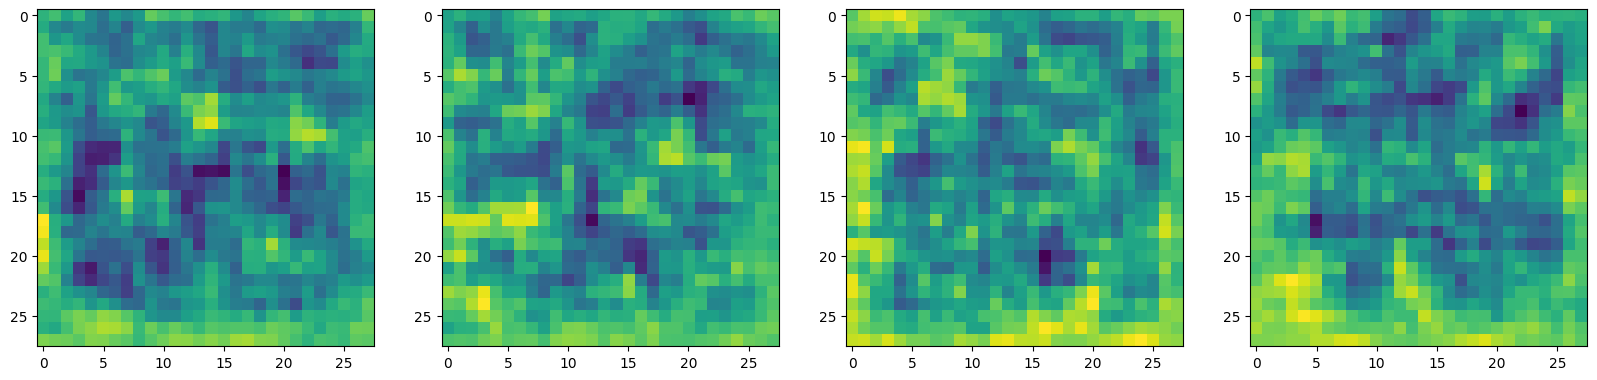

In [36]:
# Generate Image
img = generator.predict(np.random.randn(4, 128, 1)) # Generating 4 different random-Images
# Visualize Generated Image.
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for indx in range(4):
    ax[indx].imshow(np.squeeze(img[indx])) # np.squeeze() - Removes dimentions of size 1(simplifies data shape and makes simpler to work with) eg: (28, 28, 1) ---> (28, 28)

#### 3.3 Build Discriminator

In [37]:
def discriminator():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Reduce pooling; using max pooling with size 2
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample to 14x14

    # 2nd Convolutional Layer
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Remove pooling layer to maintain dimensions
    # model.add(MaxPooling2D(pool_size=(2, 2)))  # Commenting this out

    # 3rd Convolutional Layer
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Adding a pooling layer, keeping dimensions in check
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample to 7x7

    # 4th Convolutional Layer
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten the output
    model.add(Flatten())

    # Dense layer for binary classification (real/fake)
    model.add(Dense(1, activation='sigmoid'))

    return model


In [38]:
discriminator = discriminator()
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,385 (1.53 MB)

 Trainable params: 400,385 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Construct Training Loop

#### 4.1 Setup Losses and Optimizers

In [39]:
# Training-Loop: We need to train both Generator and Discriminator side-by-side(should balance training-phase of both --- difficult part), unlike using model.fit().
from tensorflow.keras.optimizers import Adam # Optimizer(updates/adjustes the weights based on loss-function during training) for both generator and dicriminator.
from tensorflow.keras.losses import BinaryCrossentropy # Loss-Function used for binary-classifiction. It measures the difference between predicted and actual outcomes.
# NOTE: 
# In GANs "BinaryCrossentropy" is used for Generator and Discriminator.
# Binary Crossentropy helps the generator learn to fool the discriminator by minimizing the difference between fake and real image classifications.
#In the context of GANs, these tools are critical for balancing the adversarial training between the generator (which creates fake data) 
# and the discriminator (which tries to identify real vs. fake data).

In [40]:
# Create Instances
opt_gen = Adam(learning_rate = 0.0001) # Optimizer for Generator.
opt_disc = Adam(learning_rate = 0.00001) # Optimizer for Discriminator.

loss_gen = BinaryCrossentropy() # Loss for Generator
loss_disc = BinaryCrossentropy() # Loss for Discriminator

 #### 4.2 Build Subclasses Model

In [41]:
from tensorflow.keras.models import Model # Model-Class(Base-Model) is primarily used to define "custom neural-network architectures".
# There is our model is combination of "Generator" and "Discriminator". And we need to train them together.

In [78]:
# Import required libraries
import tensorflow as tf
from keras.models import Model

# Creating Sub-Class from "Model-Class".
class FashionGAN(Model):  # Copy-Constructor.
    def __init__(self, generator, discriminator, *args, **kwargs):  # *args and **kwargs are positional arguments.
        super().__init__(*args, **kwargs)  # Call Super-Class Constructor.

        # Initializing
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, opt_gen, opt_disc, loss_gen, loss_disc, *args, **kwargs):
        super().compile(*args, **kwargs)  # Call Super-Class Constructor.

        # Initializing Optimizer and Loss for gen and disc.
        self.opt_gen = opt_gen
        self.opt_disc = opt_disc
        self.loss_gen = loss_gen
        self.loss_disc = loss_disc

    def call(self, inputs):
        # Extract the image tensor from the dictionary (inputs)
        images = inputs

        # Create random noise based on the batch size
        noise = tf.random.normal([tf.shape(images)[0], 128])
        
        # Generate images using the noise
        generated_images = self.generator(noise)
        return generated_images

    def train(self, batch):
        real_img = batch  # Batch of 128 Images.
        fake_img = self.generator(tf.random.normal((128, 128, 1)), training=False)  # Generates Fake-Images(batch-128) from noise(random data) and we are just predicting(not training).

        # Train "Discriminator"
        with tf.GradientTape() as tape:  # Keeps track of operations inside "with-block".
            # 1. Pass Real and Fake images to the Discriminator - to get prediction(value) for calculating loss.
            real_pred = self.discriminator(real_img, training=True)  # training=True ---> Activates dropout-layer.
            fake_pred = self.discriminator(fake_img, training=True)
            realFake_pred = tf.concat([real_pred, fake_pred], axis=0)  # Concatenate fake and real predictions(total).

            # 2. Create labels for Real and Fake Images - Actual Binary_Values.
            realFake_actual = tf.concat([tf.zeros_like(real_pred), tf.ones_like(fake_pred)], axis=0)  # Used to compute the "loss" when training the discriminator.

            # 2.1. Add some noise - Adding noise is a technique used to make the model more robust, preventing the discriminator from becoming too confident or overfitting.
            real_noise = 0.15 * tf.random.uniform(tf.shape(real_pred))  # Fixed typo here: "unifrom" to "uniform"
            fake_noise = -0.15 * tf.random.uniform(tf.shape(fake_pred))
            realFake_actual += tf.concat([real_noise, fake_noise], axis=0)  # Injecting noise to actual outputs.

            # 3. Calculate Loss
            total_loss_disc = self.loss_disc(realFake_actual, realFake_pred)

        # 4. Apply Backpropagation - Neural Network learns (update weights)
        dGradient = tape.gradient(total_loss_disc, self.discriminator.trainable_variables)  # Calculate Gradient.
        self.opt_disc.apply_gradients(zip(dGradient, self.discriminator.trainable_variables))  # Fixed typo "apply_gradient" to "apply_gradients"

        # Train "Generator"
        with tf.GradientTape() as g_tape:
            # 1. Generate fake-Images (using generator).
            fake_img = self.generator(tf.random.normal((128, 128, 1)), training=True)  # Set training=True for generator training

            # 2. Pass Fake-images into discriminator, creating adversary.
            disc_pred = self.discriminator(fake_img, training=False)  # Discriminator Prediction, we want discriminator only to predict, not to train.

            # 3. Calculate Loss.
            total_loss_gen = self.loss_gen(tf.zeros_like(disc_pred), disc_pred)  # 0 - discriminator_predicted_value.

        # 4. Apply Backpropagation - Neural Network learns (updates parameters).
        gGradient = g_tape.gradient(total_loss_gen, self.generator.trainable_variables)  # Fixed typo here: "total_loss" to "total_loss_gen"
        self.opt_gen.apply_gradients(zip(gGradient, self.generator.trainable_variables))  # Fixed typo "apply_gradient" to "apply_gradients"

        return {"disc_loss": total_loss_disc, "gen_loss": total_loss_gen}  # Returning loss metrics.


In [74]:
# Create the instance of FashionGAN.
fGAN = FashionGAN(generator, discriminator)

# Define optimizers and loss functions.
opt_gen = tf.keras.optimizers.Adam(learning_rate=0.0002)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.00002)
loss_fn = tf.keras.losses.BinaryCrossentropy()  # Loss function for both generator and discriminator

# Compile the model.
fGAN.compile(opt_gen=opt_gen, opt_disc=opt_disc, loss_gen=loss_fn, loss_disc=loss_fn)

#### 4.3 Build Callback

In [79]:
# Why Callbacks? 
# Callbacks are allows to interact, monitor and track the training-process(metrics like loss or accuracy), which enables us to dynamically modify the training behavior(saving a model, adjusting learning rates, or stopping training early)
import os
from tensorflow.keras.preprocessing.image import array_to_img # to convert numpy-array to an image-object.
from tensorflow.keras.callbacks import Callback # Callbacks are passed during training. 

In [80]:
# Custom Callback for saving generated images after each epoch - Interacting to training process.
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128, output_dir='images'):
        self.num_img = num_img  # Number of images to generate
        self.latent_dim = latent_dim  # Dimension of the latent vector for the generator
        self.output_dir = output_dir  # Directory where images will be saved
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)  # Create directory if it doesn't exist

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vec = tf.random.uniform((self.num_img, self.latent_dim, 1))  # Generate latent vectors
        img_gen = self.model.generator(random_latent_vec)  # Generate images using the generator
        img_gen *= 255  # Scale images back to [0, 255] pixel range
        img_gen = img_gen.numpy()  # Convert Tensor to NumPy array for saving

        # Save generated images
        for i in range(self.num_img):
            img = array_to_img(img_gen[i])
            img.save(os.path.join(self.output_dir, f'generated_img_{epoch}_{i}.png'))


#### 4.4 Train

In [81]:
# Train the GAN with the preprocessed dataset
h = fGAN.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20


ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

#### 4.5 Review Performance

## 5. Test Out the Generator